Importing libraries

In [0]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs
import graphviz
from IPython.display import display
from pandas import DataFrame
from matplotlib import pyplot
import random

Creating a dummy random subset with 4-features of

In [0]:
#Using the 4-class to be 
	
# generate 2d classification dataset
X, y = make_blobs(n_samples=100, centers=[(0,0),(2,2),(2,0),(0,2)], n_features=2, cluster_std= 0.75)

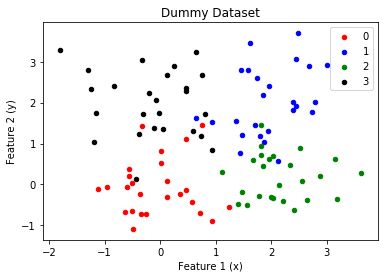

In [3]:
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green', 3:'black'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.title('Dummy Dataset')
pyplot.xlabel('Feature 1 (x)')
pyplot.ylabel('Feature 2 (y)')
pyplot.show()

In [4]:
df.head()
#The data is all numeric but it can be categorical as the decision tree accepts categorical data
#To explain the working we are not adding any categorical feature.

,x,y,label
0,0.019746,0.526741,0
1,0.938733,1.531691,1
2,-0.948553,-0.061637,0
3,1.958209,2.406845,1
4,-0.080092,2.057816,3


Splitting this dummy data-set

In [0]:
from sklearn.model_selection import train_test_split
X = df.drop(['label'],axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [0]:
#Defining a function to partition a node 
def partition(df, column, value):
    """Partitions a dataset.

    For each row in the dataset, check if it matches the question. If
    so, add it to 'true rows', otherwise, add it to 'false rows'.
    Condition comes in as a tuple with fist value being the column label used to partition and the other value being the point of split
    """
    # Compare the feature value in an example to the feature value in this question.
    val = (column <= value)
    return df[val], df[~val]

In [7]:
#Checking if the function works
lesseq_rows, more_rows = partition(X_train, X_train['x'], 3)
print(lesseq_rows.head())
print(more_rows.head())

           x         y
2  -0.948553 -0.061637
73  0.128429 -0.296108
97  0.125140  2.670439
62  2.551087  0.095062
19  1.406756 -0.475903
           x         y
21  3.189645 -0.351719


Writing a function to compute gini compute the gini impurity of a node.

Gini impurity for a set of items with $J$ classes, if $p_i$ is the fraction of items labeld class $i$ in the set, with $i \in \{1, 2, \cdots, J\}$. Then we have,

$$I_G(p) = \sum_{i=1}^J p_i \sum_{k \neq i} p_k = \sum_{i=1}^J p_i(1-p_i) = \sum_{i=1}^J (p_i - p_i^2)
= \sum_{i=1}^J p_i - \sum_{i=1}^J p_i^2 = 1 - \sum_{i=1}^J p_i^2.$$

Not doing it for entropy because gini impurity is easier to compute.

In [0]:
#Computing gini impurity 
def gini(X_node_column):
  ''' Computing gini impurity
    Function takes in a column and returns the gini impurity of the data based on that feature.
  '''
  counts = X_node_column.value_counts()
  return 1 - ((counts / len(X_node_column)) ** 2).sum()

In [9]:
#Confirming if the function works
print('Original Impurity: {}'.format(gini(y_train)))
print('Right side Impurity after split: {}'.format(gini(y_train[more_rows.index])))
print('Left side Impurity after split: {}'.format(gini(y_train[lesseq_rows.index])))

Original Impurity: 0.7465625
Right side Impurity after split: 0.0
Left side Impurity after split: 0.7450729049831758


Defining a function to compute information gain based on a particular split

In [0]:
#Computing information gain
def info_gain(left, right, current_uncertainty):
  """Information Gain.
    The uncertainty of the starting node, minus the weighted impurity of
    two child nodes. 
  """
  p = float(len(left)) / (len(left) + len(right))
  return current_uncertainty - p * gini(y_train[left.index]) - (1 - p) * gini(y_train[right.index])

In [11]:
#Confirming if the function works
print('Information Gain with the used split x>3: {}'.format(info_gain(lesseq_rows, more_rows, gini(y[X_train.index]))))

Information Gain with the used split x>3: 0.010803006329113907


Now we can have different splits and we need to find the best split in terms of information gain so writing a function to find the best split.

In [0]:
def find_best_split(rows, rf = 0):
    """Find the best question to ask by iterating over every feature / value
    and calculating the information gain."""
    best_gain = 0  # keep track of the best information gain
    best_feature_to_split = None  # keep train of the feature / value that produced it
    best_feature_split_value = None
    current_uncertainty = gini(y_train[rows.index])
    features = rows.columns
    if rf == 1:
      features = np.random.choice(features, size=int(len(features)/2), replace=False)
    for col in features:  # for each feature
        # unique values in the column
        values = rows[col].unique()
        for val in values:  # for each value
            # try splitting the dataset
            lesseq_rows, more_rows = partition(rows, rows[col], val)

            # Skip this split if it doesn't divide the
            # dataset.
            if len(lesseq_rows) == 0 or len(more_rows) == 0:
                continue

            # Calculate the information gain from this split
            gain = info_gain(lesseq_rows, more_rows, current_uncertainty)

            #Checking the best gain and using that
            if gain >= best_gain:
                best_gain, best_feature_to_split, best_feature_split_value = gain, col, val

    return best_gain, best_feature_to_split, best_feature_split_value

In [13]:
best_gain, best_feature_to_split, best_feature_split_value = find_best_split(X_train)
print('Best split of the training dataset is {} < {}, it provides information gain of {}'.format(best_feature_to_split, best_feature_split_value, best_gain))

Best split of the training dataset is x < 0.9371436239682427, it provides information gain of 0.24046493902439026


Using these functions we can now build a decision tree the approach is quite straightforward:

- Find the best split of current dataset
- If splitable, then
  - Create a decision node
  - Split dataset into left and right
  - Recursively call split on left and right
- If not splitable:
  - Create a leaf node

Classifying nodes into two types leaves and nodes. Leaves are termating nodes whereas nodes are normal nodes where we perform splitting. 

In [0]:
class Leaf:
    """A Leaf node is the final node of the decision tree where the max-depth or max-# of values in a nodes is reaches or the node has no uncertainity.

    This holds a dictionary of class (e.g., "Apple") -> number of times
    it appears in the rows from the training data that reach this leaf.
    """
    def __init__(self, rows):
        self.predictions = y_train[rows.index].value_counts()

In [0]:
class Node:
    """A Node of the decision tree.
    """
    def __init__(self, best_feature, split_value, true_branch, false_branch):
        self.best_feature = best_feature
        self.split_value = split_value
        self.true_branch = true_branch
        self.false_branch = false_branch

Using these nodes to build a decision tree

In [0]:
def build_tree(rows, max_height =10, rf = 0):
    """Builds the tree.
    Rules of recursion: 1) Check max height. 2) Start by checking
    for the base case (no further information gain). 3) Prepare for
    giant stack traces.
    """

    # Try partitioing the dataset on each of the unique attribute,
    # calculate the information gain and return the question that produces the highest gain.
    gain, feature_to_split, split_value  = find_best_split(rows, rf)

    # Base case: no further info gain
    # Since we can ask no further questions,
    # we'll return a leaf.
    if gain == 0:
      return Leaf(rows)
    #If the max-height is reached we will return a Leafnode
    if max_height == 0:
      return Leaf(rows)
    

    # If we reach here, we have found a useful feature / value
    # to partition on.
    less_rows, more_rows = partition(rows, rows[feature_to_split], split_value)

    # Recursively build the true branch.
    true_branch = build_tree(less_rows, max_height -1, rf)

    # Recursively build the false branch.
    false_branch = build_tree(more_rows, max_height -1, rf)

    # Return a Question node.
    # This records the best feature / value to ask at this point,
    # as well as the branches to follow
    # depending on the answer.
    return Node(feature_to_split, split_value, true_branch, false_branch)

In [0]:
dt=build_tree(X_train, 2)

In [0]:
#Writing a function to visualize this tree
import random, string
def treenode2dot(dot, node):
    name = ''.join(random.choice(string.ascii_uppercase) for _ in range(4))
    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        dot.attr('node', fillcolor='#CED9D9')
        pred = '\n'.join('Label %s: %s' % p for p in node.predictions.to_dict().items())
        dot.node(name, pred)
        return name

    # Print the question at this node
    dot.attr('node', fillcolor='#A2EBB4')
    dot.node(name, str(node.best_feature+ '<='+ str(node.split_value)))

    # Call this function recursively on the true branch
    left = treenode2dot(dot, node.true_branch)
    right = treenode2dot(dot, node.false_branch)
    dot.edge(name, left, 'true')
    dot.edge(name, right, 'false')
    return name

def tree2graphviz(trees):
    edge_attr = dict(fontsize='9', color='#333333', fontname='Arial')
    node_attr = dict(shape='box', style='filled', color='#333333', fontsize='9', fontname='Arial')
    dot = graphviz.Digraph(edge_attr=edge_attr, node_attr=node_attr)
    if isinstance(trees, list):
        for tree in trees:
            g = graphviz.Digraph(edge_attr=edge_attr, node_attr=node_attr)
            treenode2dot(g, tree)
            dot.subgraph(g)
    else:
        treenode2dot(dot, trees)
    return dot

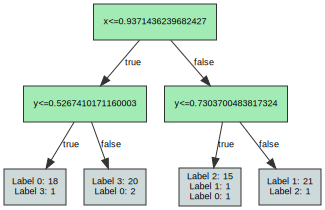

In [19]:
tree2graphviz(dt)

Now we to predict our random input points using the tree built.

In [0]:
#The predict function will just traverse the rows and then check which leaf the row ends up in predicting that row's majority as the label of input row
def prediction(row, node):
    """Recursing from the root to the leaf of the node."""

    # Base case: If the leaf is reached
    if isinstance(node, Leaf):
        counts = node.predictions
        total = counts.sum()
        probs = {}
        for label in counts.index:
          probs[label] = str(int(counts[label] / total * 100)) + "%"
        return probs

    # Decide whether to follow the true-branch or the false-branch.
    # Compare the feature / value stored in the node to the example we're considering.
    if (row[node.best_feature] <= node.split_value):
        return prediction(row, node.true_branch)
    else:
        return prediction(row, node.false_branch)

In [21]:
#Testing
for index, row in X_test.iterrows():
  print ("actual label: {} \t prediction: {} ".format(y_test[index], prediction(row, dt)))

actual label: 2 	 prediction: {2: '88%', 1: '5%', 0: '5%'} 
actual label: 2 	 prediction: {2: '88%', 1: '5%', 0: '5%'} 
actual label: 2 	 prediction: {2: '88%', 1: '5%', 0: '5%'} 
actual label: 0 	 prediction: {0: '94%', 3: '5%'} 
actual label: 3 	 prediction: {3: '90%', 0: '9%'} 
actual label: 3 	 prediction: {3: '90%', 0: '9%'} 
actual label: 2 	 prediction: {1: '95%', 2: '4%'} 
actual label: 1 	 prediction: {1: '95%', 2: '4%'} 
actual label: 0 	 prediction: {3: '90%', 0: '9%'} 
actual label: 0 	 prediction: {3: '90%', 0: '9%'} 
actual label: 2 	 prediction: {2: '88%', 1: '5%', 0: '5%'} 
actual label: 0 	 prediction: {0: '94%', 3: '5%'} 
actual label: 2 	 prediction: {1: '95%', 2: '4%'} 
actual label: 1 	 prediction: {1: '95%', 2: '4%'} 
actual label: 2 	 prediction: {2: '88%', 1: '5%', 0: '5%'} 
actual label: 2 	 prediction: {2: '88%', 1: '5%', 0: '5%'} 
actual label: 3 	 prediction: {3: '90%', 0: '9%'} 
actual label: 1 	 prediction: {3: '90%', 0: '9%'} 
actual label: 2 	 prediction

This dummy dataset is easily seperable therefore we get high train and test accuracy.

Visualizing the decision boundary.

In [0]:
#A function to get prediction label 
def predict_label(row, node):
    """Recursing from the root to the leaf of the node."""

    # Base case: If the leaf is reached
    if isinstance(node, Leaf):
        counts = node.predictions
        return counts.idxmax()
    
    # Decide whether to follow the true-branch or the false-branch.
    # Compare the feature / value stored in the node to the example we're considering.
    if (row[node.best_feature] <= node.split_value):
        return predict_label(row, node.true_branch)
    else:
        return predict_label(row, node.false_branch)

In [23]:
#Testing
from sklearn.metrics import accuracy_score
y_train_pred = []
for index, row in X_train.iterrows():
  y_train_pred.append(predict_label(row, dt))

y_test_pred = []
for index, row in X_test.iterrows():
  y_test_pred.append(predict_label(row, dt))

print('Training Accuracy of the Decision Tree model is {}%'.format(accuracy_score(y_train, y_train_pred)*100))
print('Testing Accuracy of the Decision Tree model is {}%'.format(accuracy_score(y_test, y_test_pred)*100))

Training Accuracy of the Decision Tree model is 92.5%
Testing Accuracy of the Decision Tree model is 75.0%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: The following kwargs were not used by contour: 'clim'


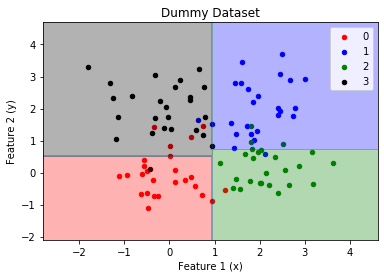

In [24]:
colors = {0:'red', 1:'blue', 2:'green', 3:'black'}
n_classes = 4
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])

xx, yy = np.meshgrid(np.linspace((min(X['x'])-1), (max(X['x'])+1), num=200), np.linspace((min(X['y'])-1), (max(X['y'])+1), num=200))
shp = xx.shape

Mesh_df = pd.DataFrame({'x': xx.ravel(), 'y':yy.ravel()})
Z = []
for idx, row in Mesh_df.iterrows():
  Z.append(predict_label(row, dt))
Z = np.asarray(Z)
Z = Z.reshape(xx.shape)

contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           colors = ['red', 'blue', 'green', 'black'], clim=(y.min(), y.max()),
                           zorder=1)

pyplot.title('Dummy Dataset')
pyplot.xlabel('Feature 1 (x)')
pyplot.ylabel('Feature 2 (y)')
pyplot.show()

Now trying to build the random forest.

For building a random-forest we need a m-different subsets of original data with sampling

In [25]:
#Creating subsets of training data

#Ideally we create N-random subsets of the original set but building the dataset with replacement, but we can also create smaller subsamples
def sub_set(original, subset_ratio):
    """Create a random subsample from the dataset with replacement allowable"""
    n = len(original)
    n_sample = round(n * subset_ratio)
    index = np.random.choice(np.arange(n), size=n_sample, replace=True)
    return original.iloc[index]

#Checking
sub_set(X_train, 0.1)

,x,y
72,0.935615,0.839787
22,1.953100,0.632405
57,-1.183177,1.038173
66,0.798983,1.727363
4,-0.080092,2.057816
9,-0.362454,-0.236903
34,-0.321157,3.036436
12,1.360855,1.545864


Algorithm to build the random forest:

- Sample a subset.
- Creating a tree with the subset, with each level using features out of a set of random features(length of this is kept 1/2 len of features for this dummy example) selected of the original set of features. 
- Repeat this `n_trees` times.
- Then average the predictions of all the trees to make a random prediction.

In [0]:
#Defining a function to create random forest
def random_forest(train, sample_size, n_trees, max_height = 10, rf = 0):
    """Random Forest Algorithm
    
    Shuffle the training dataset into 'n_trees' subsamples with the size of 'sample_size'
    Build trees based on each subsamples and apply testing dataset into each trees and count the results.
    """
    trees = list()
    for i in range(n_trees):
        #build single subsample
        sample = sub_set(train, sample_size)
        #create a single decision tree based on the subsample above
        tree = build_tree(sample, max_height, rf)
        #Collecting the trees to build the forest
        trees.append(tree)
    
    return trees

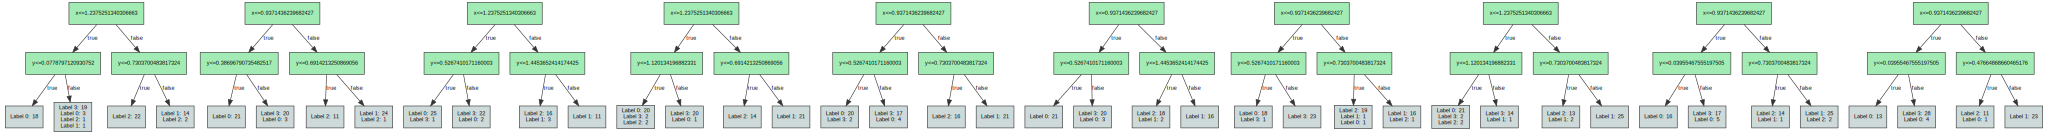

In [27]:
RF = random_forest(X_train, sample_size=1, n_trees=10, max_height = 2, rf = 0)
#Visualizing the Random Forest
tree2graphviz(RF)

The variable rf if set to one will helps the trees in forest to be more decorrelated by selecting the best feature out of a certian subset of all features.

This additional trick ensures that the trees are more-decorrelated making the reduction in variance more.

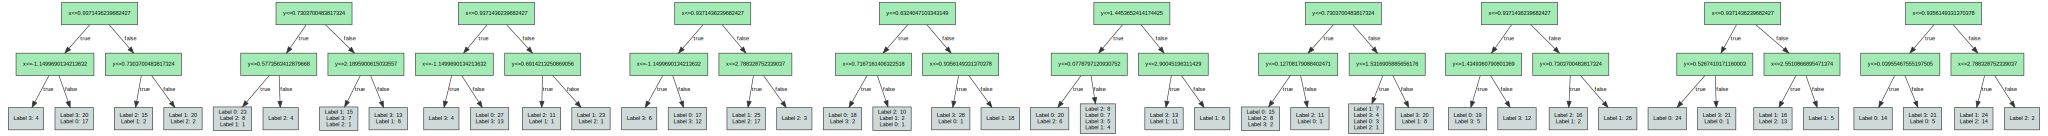

In [28]:
RF = random_forest(X_train, sample_size=1, n_trees=10, max_height = 2, rf = 1)
#Visualizing the Random Forest
tree2graphviz(RF)

Now we need to predict using the random-forest. Which can be done by using majority voting.

In [0]:
def rf_predict(RF, row):
  """Making a prediction with a list of trees in Random Forest"""
  predictions = [prediction(row, tree) for tree in RF]    
  #Sum all the votes
  probs = {0: 0, 1: 0, 2: 0, 3: 0}
  for dic in predictions:
    for label in dic.keys():
      probs[label] += int(dic[label][0:len(dic[label])-1])
  
  n_dt = len(RF)
  for key in probs.keys():
    probs[key] = str(probs[key]/n_dt) + '%'
  return probs

In [30]:
for index, row in X_test.iterrows():
  print('actual label: {} \t prediction: {}'.format(y_test[index], rf_predict(RF, row)))

actual label: 2 	 prediction: {0: '21.4%', 1: '22.5%', 2: '54.3%', 3: '0.8%'}
actual label: 2 	 prediction: {0: '4.4%', 1: '16.1%', 2: '76.7%', 3: '2.0%'}
actual label: 2 	 prediction: {0: '21.4%', 1: '27.0%', 2: '49.9%', 3: '0.8%'}
actual label: 0 	 prediction: {0: '74.6%', 1: '0.3%', 2: '8.0%', 3: '16.5%'}
actual label: 3 	 prediction: {0: '19.6%', 1: '13.8%', 2: '0.4%', 3: '65.3%'}
actual label: 3 	 prediction: {0: '19.6%', 1: '16.6%', 2: '0.0%', 3: '63.0%'}
actual label: 2 	 prediction: {0: '4.9%', 1: '68.9%', 2: '17.6%', 3: '7.6%'}
actual label: 1 	 prediction: {0: '0.0%', 1: '67.3%', 2: '13.3%', 3: '18.6%'}
actual label: 0 	 prediction: {0: '32.4%', 1: '12.7%', 2: '4.3%', 3: '49.4%'}
actual label: 0 	 prediction: {0: '21.6%', 1: '15.6%', 2: '1.0%', 3: '60.8%'}
actual label: 2 	 prediction: {0: '21.4%', 1: '22.5%', 2: '54.3%', 3: '0.8%'}
actual label: 0 	 prediction: {0: '74.6%', 1: '0.3%', 2: '8.0%', 3: '16.5%'}
actual label: 2 	 prediction: {0: '4.9%', 1: '68.9%', 2: '17.6%', 3:

Visualizing Decision Boundary

In [0]:
#A function to get prediction label 
def predictRF_label(node, row):
    """Recursing from the root to the leaf of the node."""
    pred_dict = rf_predict(node, row)
    prediction_lbl = -1
    count = 0
    for label in pred_dict.keys():
        if(count < float(pred_dict[label][0:len(pred_dict[label])-1])):
          count = float(pred_dict[label][0:len(pred_dict[label])-1])
          prediction_lbl = label
    return prediction_lbl

In [32]:
#Testing
y_train_pred = []
for index, row in X_train.iterrows():
  y_train_pred.append(predictRF_label(RF, row))

y_test_pred = []
for index, row in X_test.iterrows():
  y_test_pred.append(predictRF_label(RF, row))

print('Training Accuracy of the Random Forest model is {}%'.format(accuracy_score(y_train, y_train_pred)*100))
print('Testing Accuracy of the Random Forest model is {}%'.format(accuracy_score(y_test, y_test_pred)*100))

Training Accuracy of the Random Forest model is 92.5%
Testing Accuracy of the Random Forest model is 75.0%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: The following kwargs were not used by contour: 'clim'


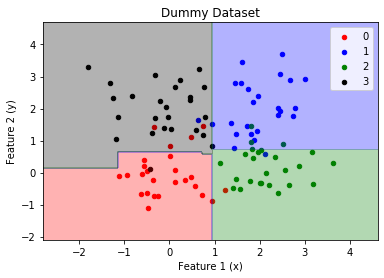

In [33]:
colors = {0:'red', 1:'blue', 2:'green', 3:'black'}
n_classes = 4
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])

xx, yy = np.meshgrid(np.linspace((min(X['x'])-1), (max(X['x'])+1), num=200), np.linspace((min(X['y'])-1), (max(X['y'])+1), num=200))
shp = xx.shape

Mesh_df = pd.DataFrame({'x': xx.ravel(), 'y':yy.ravel()})
Z = []
for idx, row in Mesh_df.iterrows():
  Z.append(predictRF_label(RF, row))
Z = np.asarray(Z)
Z = Z.reshape(xx.shape)

contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           colors = ['red', 'blue', 'green', 'black'], clim=(y.min(), y.max()),
                           zorder=1)

pyplot.title('Dummy Dataset')
pyplot.xlabel('Feature 1 (x)')
pyplot.ylabel('Feature 2 (y)')
pyplot.show()